# 1. Import các thư viện cần thiết

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import randint, uniform

import warnings
import time
import copy

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 7)
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [24]:
file_train = 'data/train/COMED_hourly_train.csv'
file_test = 'data/test/COMED_hourly_test.csv'
data_col = 'COMED_MW'
year_zooming = '2013'
sample_year_split_start = '2012'
sample_year_split_end = '2014'
cut_off_date = '2014-01-01 00:00:00'

# 2. Đọc dữ liệu

In [25]:
df_test = pd.read_csv(file_test, index_col='Datetime', parse_dates=True)
print(f"Kích thước dữ liệu test: {df_test.shape}")
df_test

Kích thước dữ liệu test: (26599, 1)


,COMED_MW
Datetime,
2015-06-13 16:00:00,13144.0
2015-06-13 17:00:00,13367.0
2015-06-13 18:00:00,13594.0
2015-06-13 19:00:00,13313.0
2015-06-13 20:00:00,12873.0
...,...
2018-01-01 20:00:00,13858.0
2018-01-01 21:00:00,13758.0
2018-01-01 22:00:00,13627.0


In [26]:
df_train = pd.read_csv(file_train, index_col='Datetime', parse_dates=True)
print(f"Kích thước dữ liệu train ban đầu: {df_train.shape}" )
df_train

Kích thước dữ liệu train ban đầu: (39898, 1)


,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0
...,...
2015-06-13 11:00:00,10276.0
2015-06-13 12:00:00,10867.0
2015-06-13 13:00:00,11578.0


In [27]:
df_train = df_train.sort_index()
print(f"Dữ liệu train bắt đầu từ {df_train.index.min()} đến {df_train.index.max()}")

Dữ liệu train bắt đầu từ 2011-01-01 01:00:00 đến 2016-01-01 00:00:00


Kiểm tra giá trị còn thiếu

In [28]:
print("Kiểm tra giá trị còn thiếu:")
missing_values = df_train.isnull().sum()
print(missing_values)

Kiểm tra giá trị còn thiếu:
COMED_MW    0
dtype: int64


Nhận xét: Không có missing value nhưng chưa chắc dữ liệu đã đầy đủ toàn bộ mốc thời gian

In [29]:
duplicate_index_count = df_train.index.duplicated().sum()
print(f"\nSố lượng index bị trùng lặp: {duplicate_index_count}")


Số lượng index bị trùng lặp: 2


Nhận xét: dữ liệu bị trùng lặp => giải quyết bằng cách dữ lại bản ghi đầu tiên.

In [30]:
if duplicate_index_count != 0:
    df_train = df_train[~df_train.index.duplicated(keep='first')]
    print(f"Kích thước sau khi xử lý trùng lặp: {df_train.shape}")

Kích thước sau khi xử lý trùng lặp: (39896, 1)


In [31]:
inferred_freq = pd.infer_freq(df_train.index)
print(f"\nTần suất thời gian được suy ra: {inferred_freq}")


Tần suất thời gian được suy ra: None


Nhận xét: dữ liệu có thể đã bị mất một vài mốc thời gian => xử lí bằng cách thêm mốc thời gian và dùng nội suy để điền missing value cho các mốc được thêm vào

In [32]:
df_train_reindexed = df_train.asfreq('H')
df_train_reindexed[data_col].interpolate(method='time', inplace=True)
df_train = df_train_reindexed

In [33]:
print("\nKiểm tra giá trị thiếu sau khi nội suy:")
missing_count = df_train.isnull().sum()
print(missing_count)


Kiểm tra giá trị thiếu sau khi nội suy:
COMED_MW    0
dtype: int64


In [34]:
print(f"\nThống kê mô tả cho {data_col}")
display(df_train[data_col].describe().apply("{:,.2f}".format))


Thống kê mô tả cho COMED_MW


count    43,824.00
mean     11,441.59
std       2,280.39
min       7,237.00
25%       9,864.58
50%      11,166.01
75%      12,453.00
max      23,753.00
Name: COMED_MW, dtype: object

# 3. Phân tích Khám phá Dữ liệu (EDA) Chi tiết

# 3.1. Trực quan hóa Tổng thể và Zoom

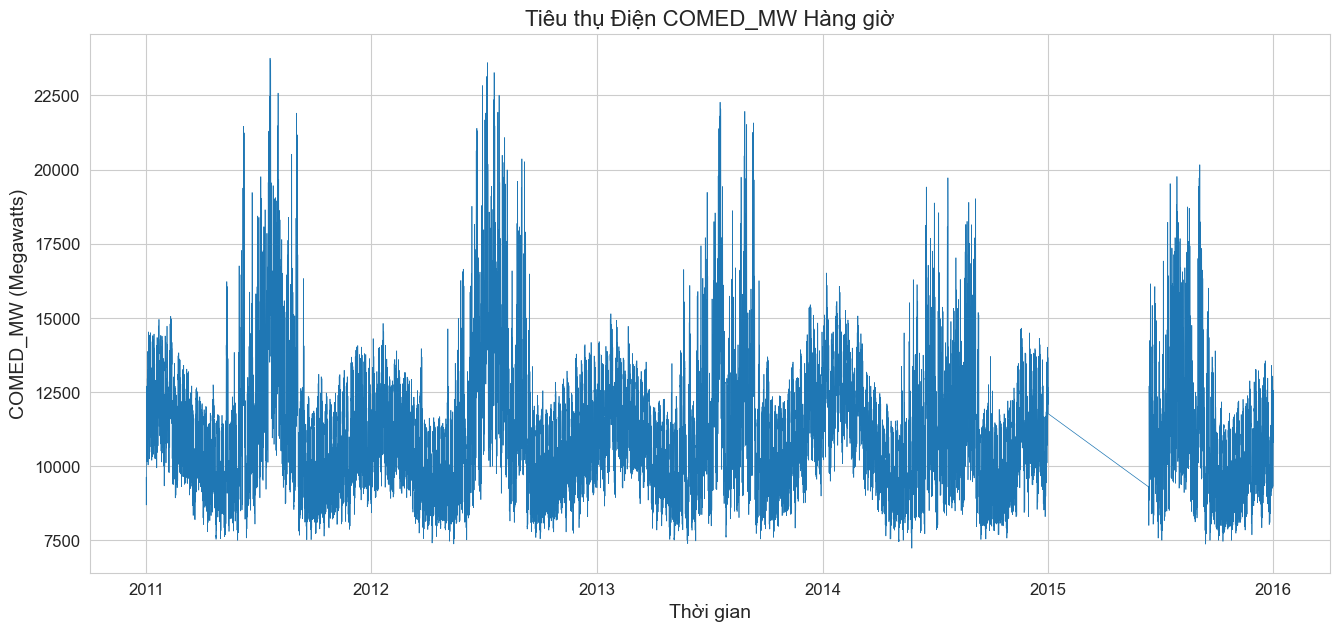

In [35]:
#print("\nBiểu đồ Chuỗi Thời gian Tổng thể:")
fig, ax = plt.subplots()
ax.plot(df_train.index, df_train[data_col], lw=0.5)
ax.set_title(f'Tiêu thụ Điện {data_col} Hàng giờ')
ax.set_xlabel('Thời gian')
ax.set_ylabel(f'{data_col} (Megawatts)')
# Định dạng trục x để hiển thị năm rõ ràng hơn
ax.xaxis.set_major_locator(mdates.YearLocator(base=1)) # Hiển thị nhãn mỗi 2 năm
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

Nhận xét ban đầu:
- **Tính mùa vụ (Seasonality):** Rất rõ ràng, có các đỉnh cao lặp lại hàng năm vào mùa hè và mùa đông, và các vùng thấp vào mùa xuân/thu.
- **Xu hướng (Trend):** Không có xu hướng tăng/giảm rõ ràng trong dài hạn. Mức tiêu thụ điện dường như ổn định trong giai đoạn 2004–2012..
- **Biến động (Volatility):** Mức độ dao động khá ổn định qua các năm. Biên độ giữa đỉnh và đáy không thay đổi quá nhiều, tuy có vài năm như 2008–2009 có vẻ hơi biến động mạnh hơn. Không có dấu hiệu dao động tăng theo thời gian.
- **Ngoại lệ tiềm năng:** Một số đỉnh cao bất thường xuất hiện, có thể liên quan đến các đợt thời tiết khắc nghiệt (nắng nóng/mùa đông lạnh bất thường).


Biểu đồ chi tiết cho Năm 2013:


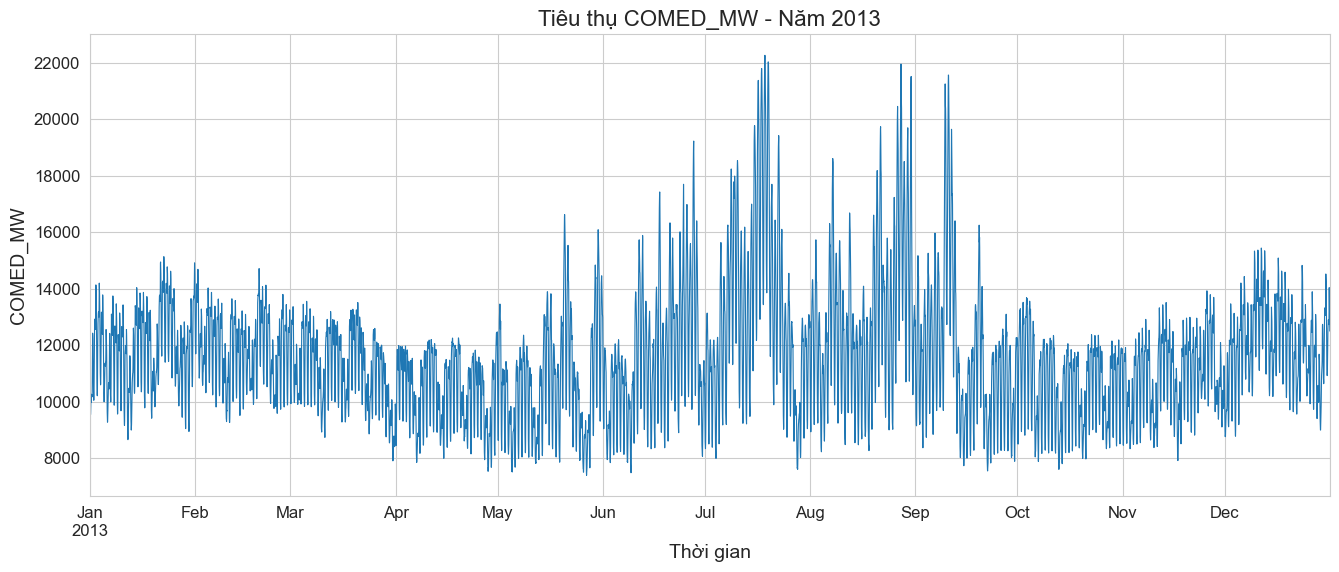

In [36]:
print(f"\nBiểu đồ chi tiết cho Năm {year_zooming}:")
fig, ax = plt.subplots(figsize=(16, 6))
df_train.loc[year_zooming, data_col].plot(ax=ax, title=f'Tiêu thụ {data_col} - Năm {year_zooming}', lw=0.8)
ax.set_ylabel(data_col)
ax.set_xlabel('Thời gian')
plt.show()

# 3.2. Phân tích Tính Mùa vụ (Seasonality)

In [37]:
df_train_eda = df_train.copy()
df_train_eda['hour'] = df_train_eda.index.hour
df_train_eda['dayofweek'] = df_train_eda.index.dayofweek
df_train_eda['dayname'] = df_train_eda.index.day_name()
df_train_eda['month'] = df_train_eda.index.month
df_train_eda['monthname'] = df_train_eda.index.month_name()
df_train_eda['year'] = df_train_eda.index.year
df_train_eda['quarter'] = df_train_eda.index.quarter
df_train_eda['dayofyear'] = df_train_eda.index.dayofyear
df_train_eda['weekofyear'] = df_train_eda.index.isocalendar().week.astype(int)


Phân tích Mùa vụ Hàng ngày:


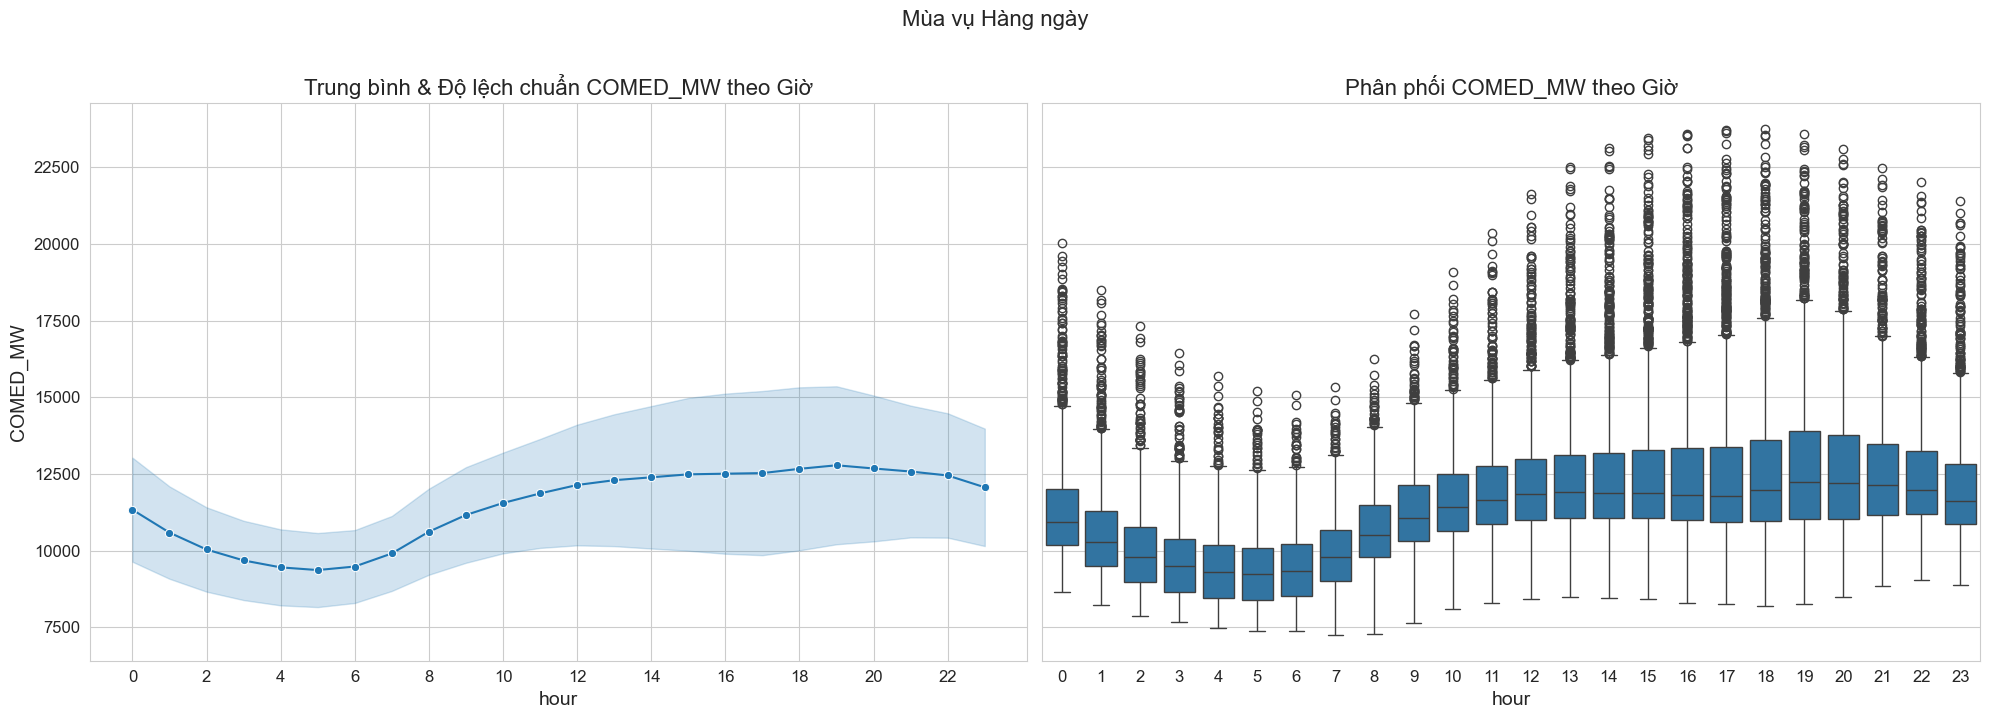

In [38]:
print("\nPhân tích Mùa vụ Hàng ngày:")
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
sns.lineplot(data=df_train_eda, x='hour', y=data_col, ax=axes[0], marker='o', errorbar='sd')
axes[0].set_title(f'Trung bình & Độ lệch chuẩn {data_col} theo Giờ')
axes[0].set_xticks(range(0, 24, 2)); axes[0].grid(True)
sns.boxplot(data=df_train_eda, x='hour', y= data_col, ax=axes[1])
axes[1].set_title(f'Phân phối {data_col} theo Giờ')
plt.suptitle('Mùa vụ Hàng ngày', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


Phân tích Mùa vụ Hàng tuần:


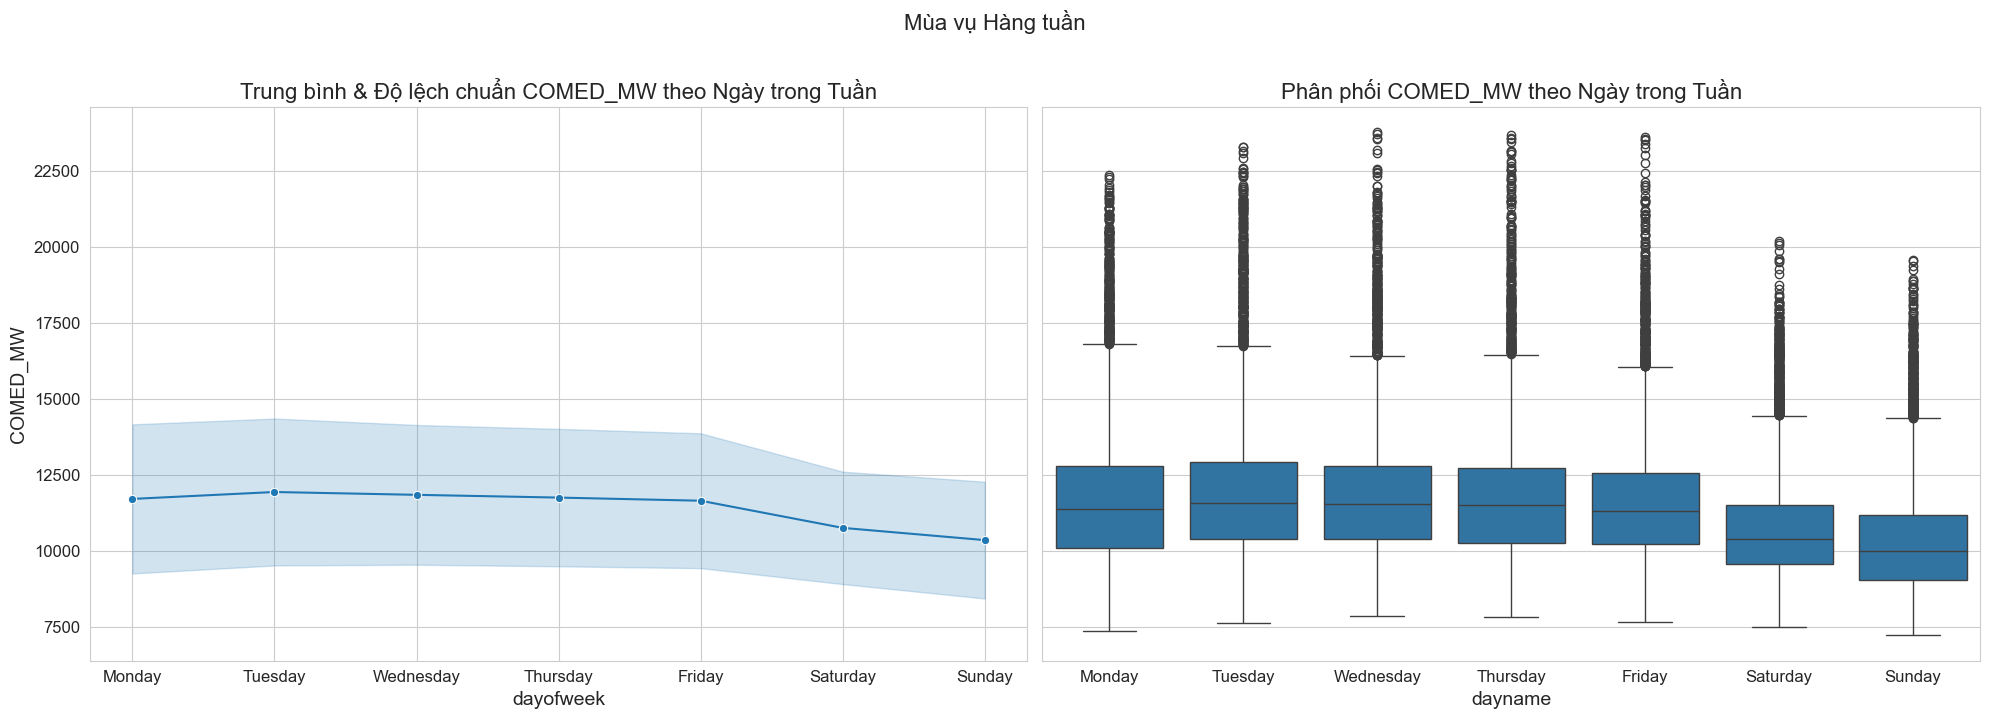

In [39]:
print("\nPhân tích Mùa vụ Hàng tuần:")
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.lineplot(data=df_train_eda, x='dayofweek', y=data_col, ax=axes[0], marker='o', errorbar='sd')
axes[0].set_title(f'Trung bình & Độ lệch chuẩn {data_col} theo Ngày trong Tuần')
axes[0].set_xticks(ticks=range(7), labels=day_order)
axes[0].grid(True)
sns.boxplot(data=df_train_eda, x='dayname', y=data_col, ax=axes[1], order=day_order)
axes[1].set_title(f'Phân phối {data_col} theo Ngày trong Tuần')
plt.suptitle('Mùa vụ Hàng tuần', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


Phân tích Mùa vụ Hàng năm:


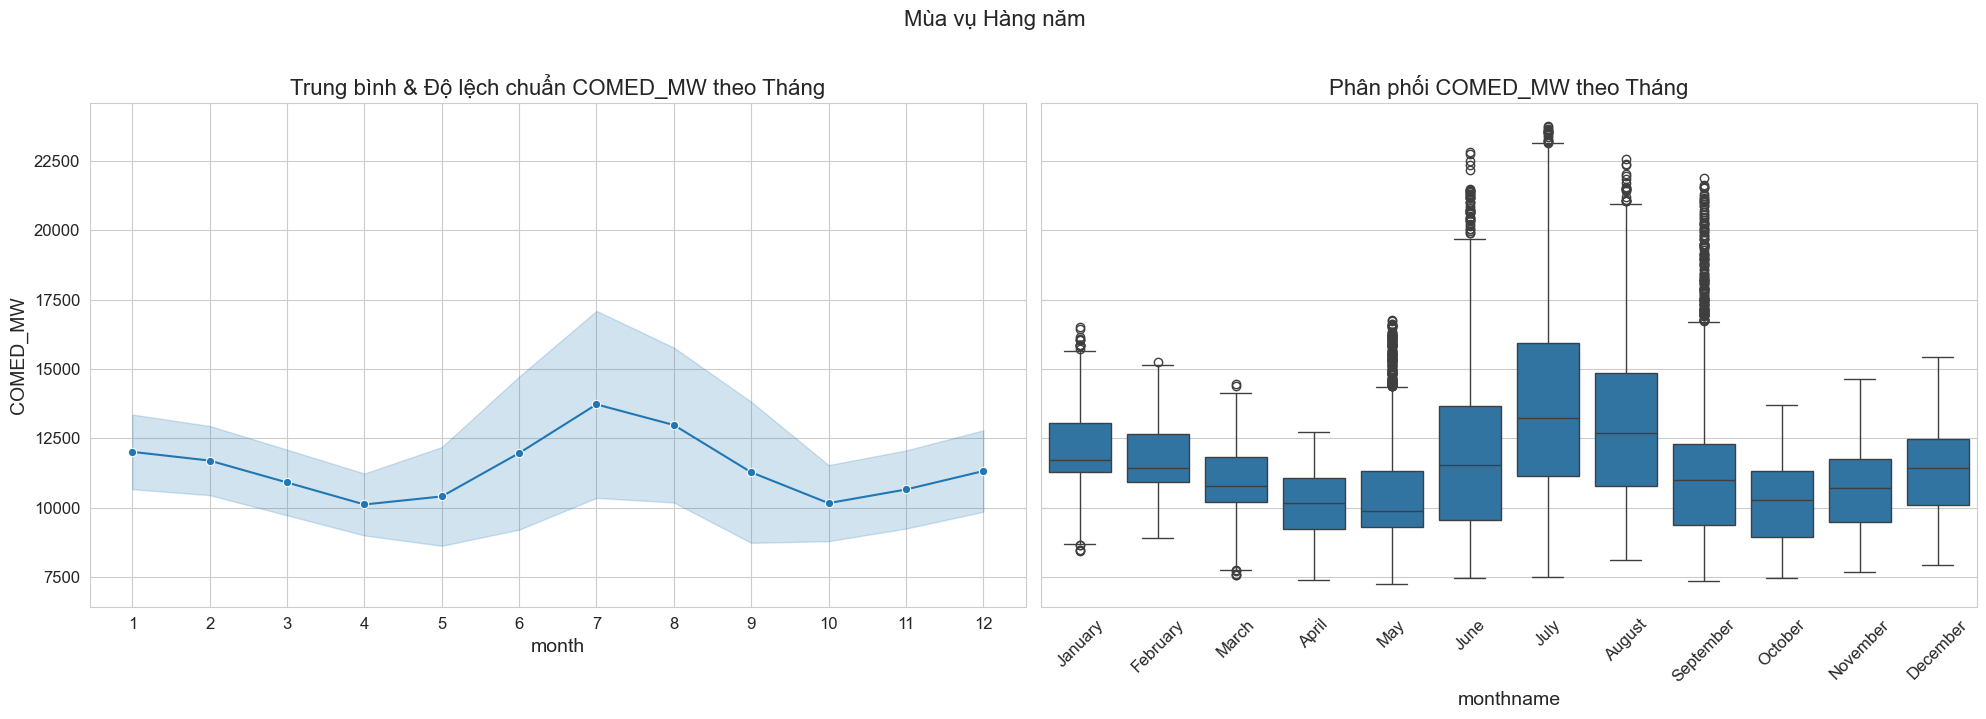

In [40]:
print("\nPhân tích Mùa vụ Hàng năm:")
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.lineplot(data=df_train_eda, x='month', y=data_col, ax=axes[0], marker='o', errorbar='sd')
axes[0].set_title(f'Trung bình & Độ lệch chuẩn {data_col} theo Tháng')
axes[0].set_xticks(range(1, 13)); axes[0].grid(True)
sns.boxplot(data=df_train_eda, x='monthname', y=data_col, ax=axes[1], order=month_order)
axes[1].set_title(f'Phân phối {data_col} theo Tháng')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('Mùa vụ Hàng năm', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# 3.3. Phân rã Chuỗi thời gian

In [41]:
df_train.head()


,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0


In [42]:
df_train.tail()

,COMED_MW
Datetime,
2015-12-31 20:00:00,12297.0
2015-12-31 21:00:00,11944.0
2015-12-31 22:00:00,11607.0
2015-12-31 23:00:00,11277.0
2016-01-01 00:00:00,10802.0



Phân rã chuỗi thời gian (Chu kỳ Năm - Mẫu 2012-2014):


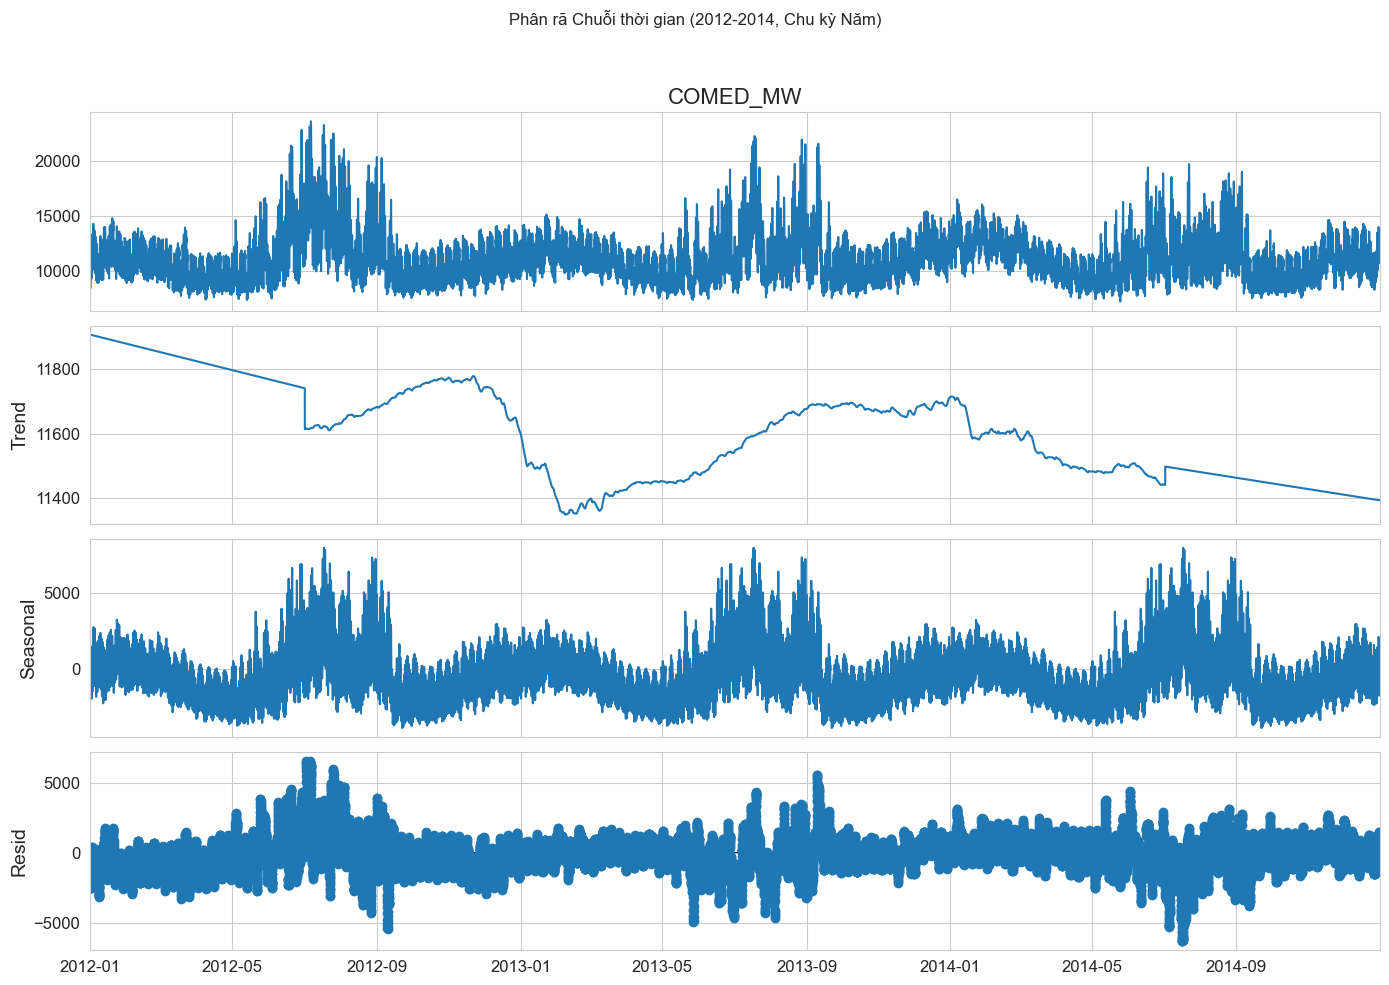

In [43]:
print(f"\nPhân rã chuỗi thời gian (Chu kỳ Năm - Mẫu {sample_year_split_start}-{sample_year_split_end}):")
period_yearly = 24 * 365
try:
    result_yearly = seasonal_decompose(df_train[data_col].loc[sample_year_split_start:sample_year_split_end], model='additive', period=period_yearly, extrapolate_trend='freq')
    fig = result_yearly.plot()
    fig.set_size_inches(14, 10)
    plt.suptitle(f'Phân rã Chuỗi thời gian ({sample_year_split_start}-{sample_year_split_end}, Chu kỳ Năm)', y=1.01)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Điều chỉnh layout
    plt.show()
except Exception as e:
    print(f"Lỗi khi phân rã theo năm: {e}")

# 3.4. Phân tích Xu hướng (Rolling Mean)


Phân tích Xu hướng bằng Rolling Mean:


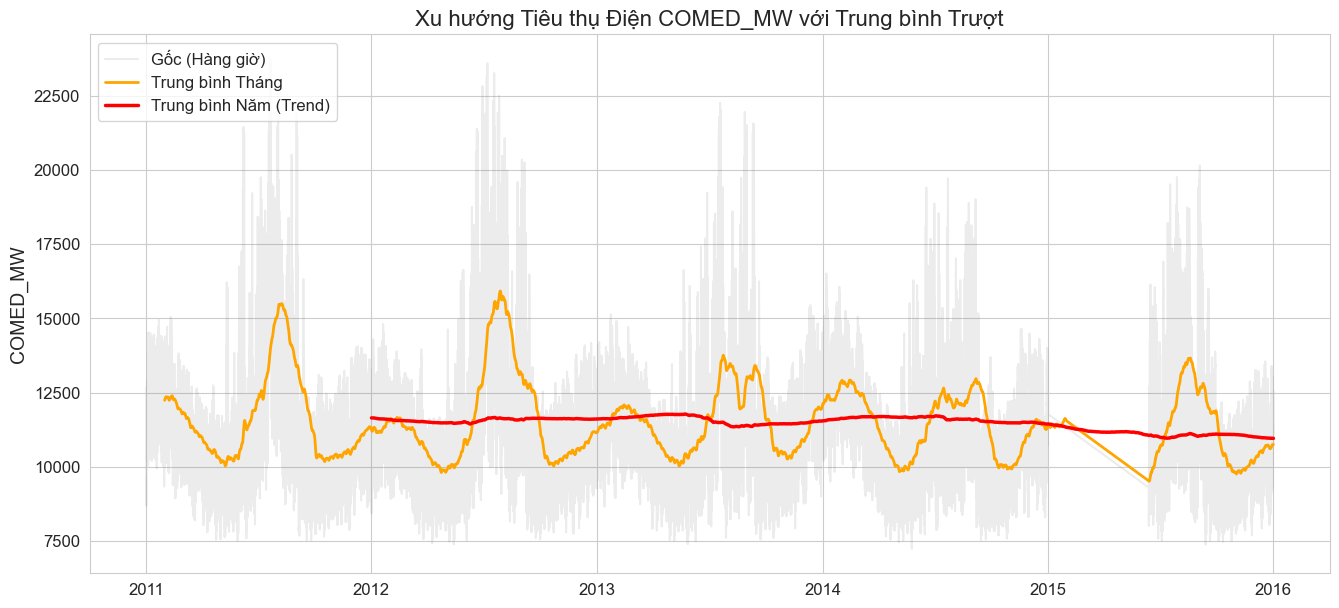

In [44]:
print("\nPhân tích Xu hướng bằng Rolling Mean:")
rolling_window_weekly = 24 * 7
rolling_window_monthly = 24 * 30
rolling_window_yearly = 24 * 365

plt.plot(df_train.index, df_train[data_col], label='Gốc (Hàng giờ)', alpha=0.15, color='gray')
plt.plot(df_train.index, df_train[data_col].rolling(window=rolling_window_monthly).mean(), label=f'Trung bình Tháng', lw=2, color='orange')
plt.plot(df_train.index, df_train[data_col].rolling(window=rolling_window_yearly).mean(), label=f'Trung bình Năm (Trend)', lw=2.5, color='red')
plt.title(f'Xu hướng Tiêu thụ Điện {data_col} với Trung bình Trượt')
plt.ylabel(data_col)
plt.legend(loc='upper left')
plt.show()

# 3.5. Phân tích Tính dừng (Stationarity) - ADF Test

In [45]:
print("\nKiểm định Tính dừng (Augmented Dickey-Fuller Test):")
result_adf = adfuller(df_train[data_col].dropna())
print(f'ADF Statistic: {result_adf[0]:.4f}')
print(f'p-value: {result_adf[1]:.4f}')
print('Critical Values:')
for key, value in result_adf[4].items(): print(f'   {key}: {value:.4f}')

if result_adf[1] <= 0.05: print("=> Kết luận: Bác bỏ H0. Chuỗi có khả năng dừng (theo ADF test).")
else: print("=> Kết luận: Không bác bỏ H0. Chuỗi có khả năng không dừng.")


Kiểm định Tính dừng (Augmented Dickey-Fuller Test):
ADF Statistic: -12.9425
p-value: 0.0000
Critical Values:
   1%: -3.4305
   5%: -2.8616
   10%: -2.5668
=> Kết luận: Bác bỏ H0. Chuỗi có khả năng dừng (theo ADF test).


Nhận xét: Mặc dù p-value nhỏ, sự hiện diện của trend và seasonality mạnh mẽ cho thấy chuỗi không dừng theo nghĩa trực quan. Mô hình cần xử lý được các thành phần này.

# 3.6. Phân tích Tự tương quan (ACF và PACF)


Biểu đồ Tự tương quan (ACF và PACF):


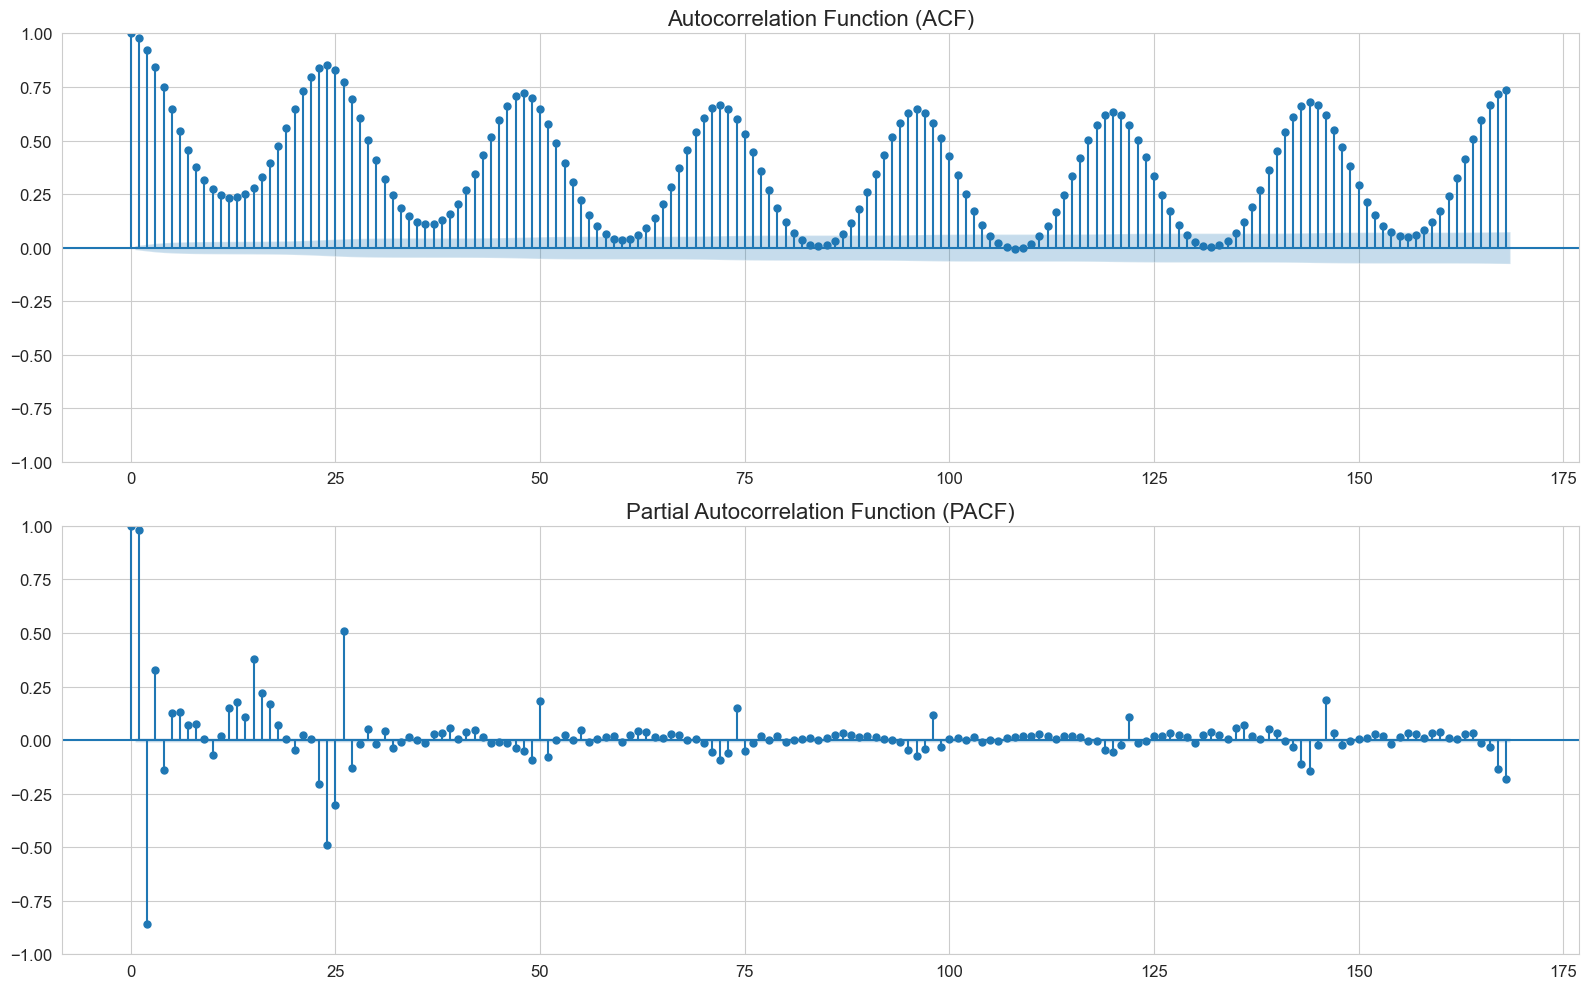

In [46]:
print("\nBiểu đồ Tự tương quan (ACF và PACF):")
lags_plot = 7 * 24 # Xem 1 tuần

fig, ax = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(df_train[data_col].dropna(), lags=lags_plot, ax=ax[0], title='Autocorrelation Function (ACF)')
ax[0].grid(True)
plot_pacf(df_train[data_col].dropna(), lags=lags_plot, ax=ax[1], title='Partial Autocorrelation Function (PACF)')
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 3.7. Phân tích Phân phối Giá trị


Phân phối của COMED_MW:


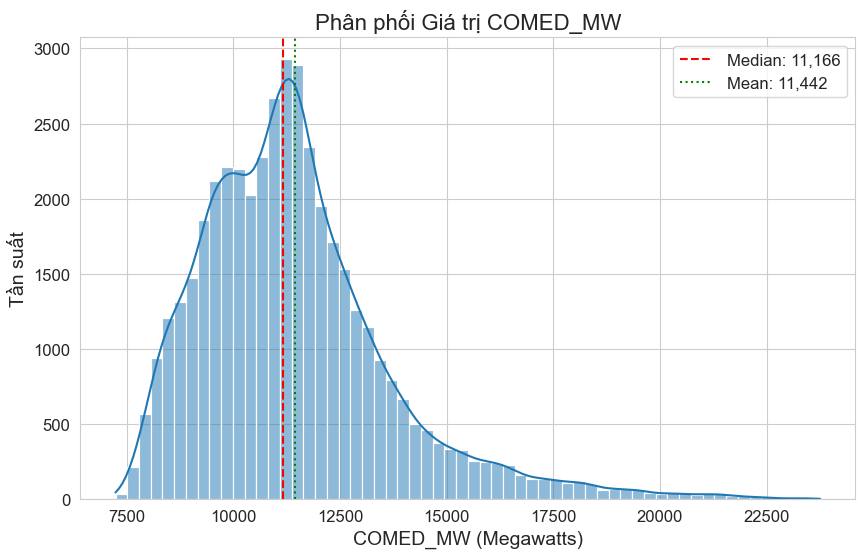

In [47]:
print(f"\nPhân phối của {data_col}:")
plt.figure(figsize=(10, 6))
sns.histplot(df_train[data_col], kde=True, bins=60)
plt.title(f'Phân phối Giá trị {data_col}')
plt.xlabel(f'{data_col} (Megawatts)')
plt.ylabel('Tần suất')
median_val = df_train[data_col].median()
mean_val = df_train[data_col].mean()
plt.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:,.0f}')
plt.axvline(mean_val, color='green', linestyle=':', label=f'Mean: {mean_val:,.0f}')
plt.legend()
plt.show()

Nhận xét: Phân phối hơi lệch phải (mean > median) và có nhiều đỉnh, không phải phân phối chuẩn.

# 3.8. Tổng kết EDA
*   **Chất lượng:** Dữ liệu có vẻ tốt, đầy đủ, liên tục theo giờ.
*   **Thành phần chính:** Xu hướng tăng nhẹ, mùa vụ rất mạnh (ngày, tuần, năm), và tự tương quan cao.
*   **Mô hình hóa:** Cần tạo đặc trưng thời gian, đặc biệt là lag/rolling features. Mô hình dựa trên cây (gradient boosting) là lựa chọn tốt. Phải chia dữ liệu theo thời gian.

# 4. Kỹ thuật Đặc trưng (Feature Engineering)

In [48]:
TARGET = data_col

Tạo các đặc trưng mới từ dữ liệu thời gian để cung cấp thông tin cho mô hình.

In [49]:
def create_time_features(df_input):
    """ Tạo các đặc trưng thời gian cơ bản và cyclical. """
    df_out = df_input.copy()
    df_out['hour'] = df_out.index.hour
    df_out['dayofweek'] = df_out.index.dayofweek
    df_out['quarter'] = df_out.index.quarter
    df_out['month'] = df_out.index.month
    df_out['year'] = df_out.index.year
    df_out['dayofyear'] = df_out.index.dayofyear
    df_out['dayofmonth'] = df_out.index.day
    df_out['weekofyear'] = df_out.index.isocalendar().week.astype(int)

    df_out['hour_sin'] = np.sin(2 * np.pi * df_out['hour']/24.0)
    df_out['hour_cos'] = np.cos(2 * np.pi * df_out['hour']/24.0)
    df_out['dayofweek_sin'] = np.sin(2 * np.pi * df_out['dayofweek']/7.0)
    df_out['dayofweek_cos'] = np.cos(2 * np.pi * df_out['dayofweek']/7.0)
    df_out['month_sin'] = np.sin(2 * np.pi * df_out['month']/12.0)
    df_out['month_cos'] = np.cos(2 * np.pi * df_out['month']/12.0)

    return df_out

In [50]:
print("1. Tạo đặc trưng thời gian cơ bản & cyclical...")
df_feature_1 = create_time_features(df_train)
print(f"  Kích thước sau bước 1: {df_feature_1.shape}")

1. Tạo đặc trưng thời gian cơ bản & cyclical...
  Kích thước sau bước 1: (43824, 15)


In [51]:
def add_lag_features(df_input, target_col, lags):
    """ Thêm các đặc trưng trễ (lag features). """
    df_out = df_input.copy()
    for lag in lags:
        df_out[f'{target_col}_lag_{lag}'] = df_out[target_col].shift(lag)
    return df_out

Chọn các lags quan trọng dựa trên EDA (ACF/PACF) và kiến thức miền
- Lags gần: 1, 2, 3 giờ
- Lags mùa vụ ngày: 24 giờ (1 ngày), 48 giờ (2 ngày)
- Lags mùa vụ tuần: 168 giờ (1 tuần)

In [52]:
lags_to_add = [1, 2, 3, 24, 48, 168]
print(f"\n2. Thêm Lag Features cho '{TARGET}' với các độ trễ: {lags_to_add}...")
df_feature_2 = add_lag_features(df_feature_1, TARGET, lags_to_add)
print(f"  Kích thước sau bước 2: {df_feature_2.shape}")
display(df_feature_2.tail())


2. Thêm Lag Features cho 'COMED_MW' với các độ trễ: [1, 2, 3, 24, 48, 168]...
  Kích thước sau bước 2: (43824, 21)


,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,COMED_MW_lag_1,COMED_MW_lag_2,COMED_MW_lag_3,COMED_MW_lag_24,COMED_MW_lag_48,COMED_MW_lag_168
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-31 20:00:00,12297.0,20,3,4,12,2015,365,31,53,-0.866025,0.500000,0.433884,-0.900969,-2.449294e-16,1.000000,12564.0,11937.0,11286.0,12781.0,12707.0,10608.0
2015-12-31 21:00:00,11944.0,21,3,4,12,2015,365,31,53,-0.707107,0.707107,0.433884,-0.900969,-2.449294e-16,1.000000,12297.0,12564.0,11937.0,12562.0,12464.0,10325.0
2015-12-31 22:00:00,11607.0,22,3,4,12,2015,365,31,53,-0.500000,0.866025,0.433884,-0.900969,-2.449294e-16,1.000000,11944.0,12297.0,12564.0,12281.0,12204.0,10133.0
2015-12-31 23:00:00,11277.0,23,3,4,12,2015,365,31,53,-0.258819,0.965926,0.433884,-0.900969,-2.449294e-16,1.000000,11607.0,11944.0,12297.0,11843.0,11773.0,9907.0
2016-01-01 00:00:00,10802.0,0,4,1,1,2016,1,1,53,0.000000,1.000000,-0.433884,-0.900969,5.000000e-01,0.866025,11277.0,11607.0,11944.0,11168.0,11045.0,9539.0


In [53]:
def add_rolling_window_features(df_input, target_col, windows, aggs=['mean', 'std']):
    """ Thêm các đặc trưng cửa sổ trượt (rolling window features). """
    df_out = df_input.copy()
    for window in windows:
        rolling = df_out[target_col].rolling(window=window, min_periods=1) # min_periods=1 để tính ngay từ đầu
        if 'mean' in aggs:
            df_out[f'{target_col}_roll_mean_{window}'] = rolling.mean()
        if 'std' in aggs:
            df_out[f'{target_col}_roll_std_{window}'] = rolling.std()
        if 'min' in aggs:
             df_out[f'{target_col}_roll_min_{window}'] = rolling.min()
        if 'max' in aggs:
             df_out[f'{target_col}_roll_max_{window}'] = rolling.max()
        # Shift kết quả rolling để tránh data leakage (sử dụng thông tin quá khứ để dự đoán hiện tại)
        cols_to_shift = [col for col in df_out.columns if f'_roll_' in col and f'_{window}' in col and f'lag' not in col]
        for col in cols_to_shift:
             df_out[col] = df_out[col].shift(1) # Shift 1 giờ
    return df_out

In [54]:
windows_to_add = [3, 6, 24, 168] # 3 giờ, 6 giờ, 1 ngày, 1 tuần
aggregations = ['mean', 'std'] # Chỉ lấy mean và std để tránh quá nhiều features
print(f"\n3. Thêm Rolling Window Features cho '{TARGET}' với cửa sổ {windows_to_add} và tổng hợp {aggregations}...")
df_feature_3 = add_rolling_window_features(df_feature_2, TARGET, windows_to_add, aggs=aggregations)
print(f"  Kích thước sau bước 3: {df_feature_3.shape}")
display(df_feature_3.tail())


3. Thêm Rolling Window Features cho 'COMED_MW' với cửa sổ [3, 6, 24, 168] và tổng hợp ['mean', 'std']...
  Kích thước sau bước 3: (43824, 29)


,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,COMED_MW_lag_1,COMED_MW_lag_2,COMED_MW_lag_3,COMED_MW_lag_24,COMED_MW_lag_48,COMED_MW_lag_168,COMED_MW_roll_mean_3,COMED_MW_roll_std_3,COMED_MW_roll_mean_6,COMED_MW_roll_std_6,COMED_MW_roll_mean_24,COMED_MW_roll_std_24,COMED_MW_roll_mean_168,COMED_MW_roll_std_168
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-31 20:00:00,12297.0,20,3,4,12,2015,365,31,53,-0.866025,0.500000,0.433884,-0.900969,-2.449294e-16,1.000000,12564.0,11937.0,11286.0,12781.0,12707.0,10608.0,11929.000000,639.037558,11573.000000,561.750834,11033.041667,1029.895414,10412.916667,1403.927035
2015-12-31 21:00:00,11944.0,21,3,4,12,2015,365,31,53,-0.707107,0.707107,0.433884,-0.900969,-2.449294e-16,1.000000,12297.0,12564.0,11937.0,12562.0,12464.0,10325.0,12266.000000,314.647422,11756.500000,592.930603,11012.875000,998.438272,10422.970238,1411.360215
2015-12-31 22:00:00,11607.0,22,3,4,12,2015,365,31,53,-0.500000,0.866025,0.433884,-0.900969,-2.449294e-16,1.000000,11944.0,12297.0,12564.0,12281.0,12204.0,10133.0,12268.333333,310.992497,11875.666667,534.701661,10987.125000,964.128546,10432.607143,1416.206284
2015-12-31 23:00:00,11277.0,23,3,4,12,2015,365,31,53,-0.258819,0.965926,0.433884,-0.900969,-2.449294e-16,1.000000,11607.0,11944.0,12297.0,11843.0,11773.0,9907.0,11949.333333,345.030916,11939.166667,459.445499,10959.041667,934.151858,10441.380952,1418.902379
2016-01-01 00:00:00,10802.0,0,4,1,1,2016,1,1,53,0.000000,1.000000,-0.433884,-0.900969,5.000000e-01,0.866025,11277.0,11607.0,11944.0,11168.0,11045.0,9539.0,11609.333333,333.506122,11937.666667,462.011977,10935.458333,917.868039,10449.535714,1419.749379


In [55]:
print("\n4. Xử lý NaN tạo ra từ Feature Engineering...")
rows_before_drop = len(df_feature_3)
df_final_features = df_feature_3.dropna()
rows_after_drop = len(df_final_features)
print(f"  Số dòng trước khi bỏ NaN: {rows_before_drop}")
print(f"  Số dòng sau khi bỏ NaN: {rows_after_drop}")
print(f"  Số dòng bị loại bỏ (do lag/rolling ban đầu): {rows_before_drop - rows_after_drop}")
print(f"  Kích thước dữ liệu cuối cùng với đầy đủ features: {df_final_features.shape}")


4. Xử lý NaN tạo ra từ Feature Engineering...
  Số dòng trước khi bỏ NaN: 43824
  Số dòng sau khi bỏ NaN: 43656
  Số dòng bị loại bỏ (do lag/rolling ban đầu): 168
  Kích thước dữ liệu cuối cùng với đầy đủ features: (43656, 29)


In [56]:
print("\nCác đặc trưng cuối cùng được tạo ra:")
final_features_list = [col for col in df_final_features.columns if col != TARGET]
print(f"  Số lượng đặc trưng: {len(final_features_list)}")
print(final_features_list)
display(df_final_features.head())


Các đặc trưng cuối cùng được tạo ra:
  Số lượng đặc trưng: 28
['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'COMED_MW_lag_1', 'COMED_MW_lag_2', 'COMED_MW_lag_3', 'COMED_MW_lag_24', 'COMED_MW_lag_48', 'COMED_MW_lag_168', 'COMED_MW_roll_mean_3', 'COMED_MW_roll_std_3', 'COMED_MW_roll_mean_6', 'COMED_MW_roll_std_6', 'COMED_MW_roll_mean_24', 'COMED_MW_roll_std_24', 'COMED_MW_roll_mean_168', 'COMED_MW_roll_std_168']


,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,COMED_MW_lag_1,COMED_MW_lag_2,COMED_MW_lag_3,COMED_MW_lag_24,COMED_MW_lag_48,COMED_MW_lag_168,COMED_MW_roll_mean_3,COMED_MW_roll_std_3,COMED_MW_roll_mean_6,COMED_MW_roll_std_6,COMED_MW_roll_mean_24,COMED_MW_roll_std_24,COMED_MW_roll_mean_168,COMED_MW_roll_std_168
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-08 01:00:00,12044.0,1,5,1,1,2011,8,8,1,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025,12724.0,13438.0,13832.0,11582.0,11268.0,9631.0,13331.333333,561.648763,13833.000000,664.180698,12843.875000,1263.723116,12101.279762,1478.554533
2011-01-08 02:00:00,11494.0,2,5,1,1,2011,8,8,1,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025,12044.0,12724.0,13438.0,11132.0,10736.0,9273.0,12735.333333,697.069102,13423.666667,889.493039,12863.125000,1247.074640,12115.642857,1466.081515
2011-01-08 03:00:00,11218.0,3,5,1,1,2011,8,8,1,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025,11494.0,12044.0,12724.0,10833.0,10418.0,9011.0,12087.333333,616.143923,12945.833333,1042.215029,12878.208333,1227.258131,12128.863095,1450.222832
2011-01-08 04:00:00,11035.0,4,5,1,1,2011,8,8,1,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025,11218.0,11494.0,12044.0,10653.0,10252.0,8741.0,11585.333333,420.506044,12458.333333,1054.260246,12894.250000,1201.610812,12142.000000,1431.688074
2011-01-08 05:00:00,10989.0,5,5,1,1,2011,8,8,1,0.965926,0.258819,-0.974928,-0.222521,0.5,0.866025,11035.0,11218.0,11494.0,10652.0,10254.0,8694.0,11249.000000,231.064926,11992.166667,937.269741,12910.166667,1172.817220,12155.654762,1409.829390


# 5. Chia Dữ liệu (Train/Validation) theo Thời gian

Xác định lại ngày/điểm chia trên df_final_features

In [57]:
val_cutoff_date = pd.to_datetime(cut_off_date)
train_data_final = df_final_features.loc[df_final_features.index <= val_cutoff_date]
val_data_final = df_final_features.loc[df_final_features.index > val_cutoff_date]
print("--- Kích thước các tập dữ liệu FE cuối cùng sau khi chia ---")
print(f"Train: {train_data_final.shape}")
print(f"Validation: {val_data_final.shape}")


--- Kích thước các tập dữ liệu FE cuối cùng sau khi chia ---
Train: (26136, 29)
Validation: (17520, 29)


Trực quan hóa chia dữ liệu

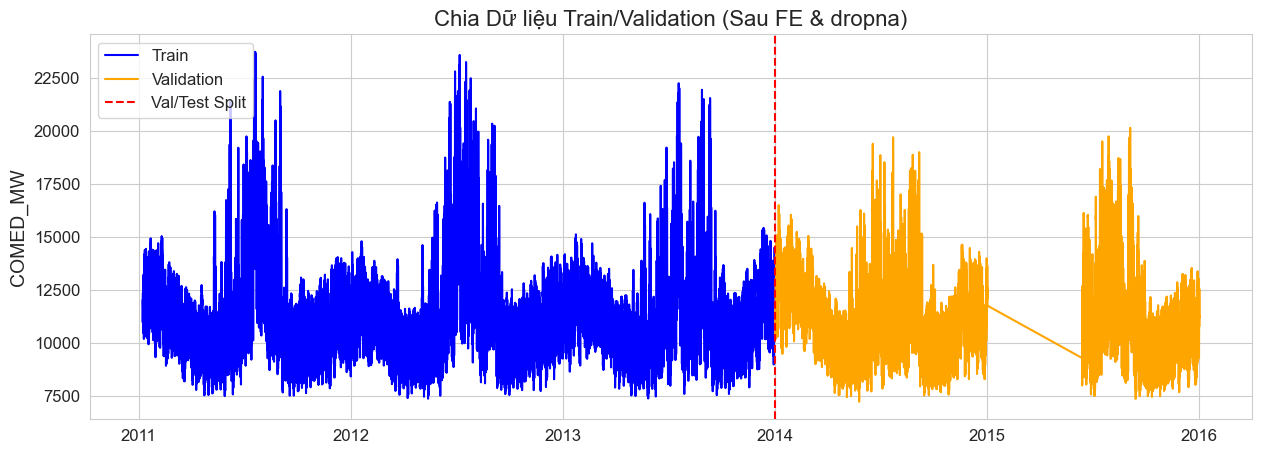

In [58]:
plt.figure(figsize=(15, 5))
plt.plot(train_data_final.index, train_data_final[TARGET], label='Train', color='blue')
plt.plot(val_data_final.index, val_data_final[TARGET], label='Validation', color='orange')
plt.axvline(val_cutoff_date, color='red', linestyle='--', label='Val/Test Split')
plt.title('Chia Dữ liệu Train/Validation (Sau FE & dropna)')
plt.ylabel(TARGET)
plt.legend(loc='upper left')
plt.show()

Tạo các tập X, y cuối cùng

In [59]:
FEATURES = final_features_list

X_train = train_data_final[FEATURES]
y_train = train_data_final[TARGET]

X_val = val_data_final[FEATURES]
y_val = val_data_final[TARGET]

In [60]:
print("\n--- Kích thước các tập X, y cho mô hình ---")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


--- Kích thước các tập X, y cho mô hình ---
X_train: (26136, 28), y_train: (26136,)
X_val: (17520, 28), y_val: (17520,)


# 6. Xây dựng & Tối ưu hóa Mô hình XGBoost

Sử dụng XGBoost và tối ưu hóa siêu tham số bằng RandomizedSearchCV.

Định nghĩa mô hình cơ sở với early stopping

In [61]:
xgb_model_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)
# Không gian siêu tham số
param_dist_xgb = {
    'n_estimators': randint(200, 1500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 11),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': [0, 0.1, 0.25, 0.5, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2, 3, 5]
}
# TimeSeriesSplit
n_splits_cv = 5
tscv = TimeSeriesSplit(n_splits=n_splits_cv)
# Randomized Search CV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_base,
    param_distributions=param_dist_xgb,
    n_iter=25,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [62]:
print("Bắt đầu tìm kiếm siêu tham số cho XGBoost (có thể mất thời gian đáng kể)...")
start_time_tuning = time.time()
random_search_xgb.fit(X_train, y_train) # Chỉ fit trên tập train
end_time_tuning = time.time()
print(f"Tìm kiếm siêu tham số hoàn tất sau {(end_time_tuning - start_time_tuning)/60:.2f} phút.")

Bắt đầu tìm kiếm siêu tham số cho XGBoost (có thể mất thời gian đáng kể)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Tìm kiếm siêu tham số hoàn tất sau 10.56 phút.


In [63]:
print("\nSiêu tham số XGBoost tốt nhất tìm được:")
best_params_xgb = random_search_xgb.best_params_
for param, value in best_params_xgb.items():
    # Làm tròn learning rate nếu nó từ phân phối uniform
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")
best_rmse_cv = -random_search_xgb.best_score_
print(f"\nRMSE tốt nhất trên Cross-Validation (Train set): {best_rmse_cv:,.2f}")


Siêu tham số XGBoost tốt nhất tìm được:
  colsample_bytree: 0.9378
  gamma: 1.0000
  learning_rate: 0.0643
  max_depth: 7
  n_estimators: 991
  reg_alpha: 0.0010
  reg_lambda: 1
  subsample: 0.7124

RMSE tốt nhất trên Cross-Validation (Train set): 191.01


Huấn luyện lại mô hình với tham số tốt nhất trên toàn bộ tập Train, sử dụng tập Val cho Early Stopping.

In [64]:
print("\nHuấn luyện mô hình XGBoost cuối cùng với tham số tốt nhất...")
# Tạo instance mới với các tham số tốt nhất
final_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    **best_params_xgb, # Truyền các tham số tốt nhất
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # Kích hoạt dừng sớm
)


Huấn luyện mô hình XGBoost cuối cùng với tham số tốt nhất...


In [65]:
start_time_final_train = time.time()
# Huấn luyện trên Train, đánh giá trên Validation để dừng sớm
final_xgb_model.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=100) # In kết quả mỗi 100 vòng để theo dõi
end_time_final_train = time.time()

[0]	validation_0-rmse:1880.05862
[100]	validation_0-rmse:176.20642
[197]	validation_0-rmse:170.30733


In [66]:
best_iteration = final_xgb_model.best_iteration if hasattr(final_xgb_model, 'best_iteration') else final_xgb_model.n_estimators
print(f"Huấn luyện hoàn tất sau {end_time_final_train - start_time_final_train:.2f} giây. Số vòng lặp tốt nhất: {best_iteration}")

Huấn luyện hoàn tất sau 4.38 giây. Số vòng lặp tốt nhất: 148


# 8. Đánh giá Mô hình Chi tiết

Đánh giá hiệu năng trên cả 3 tập dữ liệu bằng các metrics phù hợp.

In [67]:
# Dự đoán trên các tập
y_pred_train_final_xgb = final_xgb_model.predict(X_train)
y_pred_val_final_xgb = final_xgb_model.predict(X_val)

In [68]:
results_storage = {}
def evaluate_ts_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100 # Nhân 100 để ra %
    r2 = r2_score(y_true, y_pred)

    print(f"--- {model_name} ---")
    print(f"MAE : {mae:,.2f}")
    print(f"MSE : {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2  : {r2:.4f}")
    print("-" * 30)
    metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE(%)': mape, 'R2': r2}
    results_storage[model_name] = metrics
    return metrics

In [69]:
# Đánh giá hiệu năng
evaluate_ts_model(y_train, y_pred_train_final_xgb, "XGBoost Tuned (Train)")
evaluate_ts_model(y_val, y_pred_val_final_xgb, "XGBoost Tuned (Validation)")

--- XGBoost Tuned (Train) ---
MAE : 67.61
MSE : 8,698.52
RMSE: 93.27
MAPE: 0.58%
R2  : 0.9986
------------------------------
--- XGBoost Tuned (Validation) ---
MAE : 117.96
MSE : 28,624.09
RMSE: 169.19
MAPE: 1.06%
R2  : 0.9926
------------------------------


{'MAE': 117.95969920759461,
 'MSE': 28624.089575366506,
 'RMSE': 169.18655258431892,
 'MAPE(%)': 1.056275701426856,
 'R2': 0.9925866206145183}

In [70]:
val_results_final_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted (XGB)': y_pred_val_final_xgb,
    'Residual (XGB)': y_val - y_pred_val_final_xgb,
}, index=y_val.index)

print("\nSo sánh Thực tế và Dự đoán trên tập Val:")
display(val_results_final_df.head())


So sánh Thực tế và Dự đoán trên tập Val:


,Actual,Predicted (XGB),Residual (XGB)
Datetime,,,
2014-01-01 01:00:00,11562.0,11403.961914,158.038086
2014-01-01 02:00:00,11135.0,11027.879883,107.120117
2014-01-01 03:00:00,10766.0,10857.867188,-91.867188
2014-01-01 04:00:00,10489.0,10630.066406,-141.066406
2014-01-01 05:00:00,10326.0,10422.524414,-96.524414


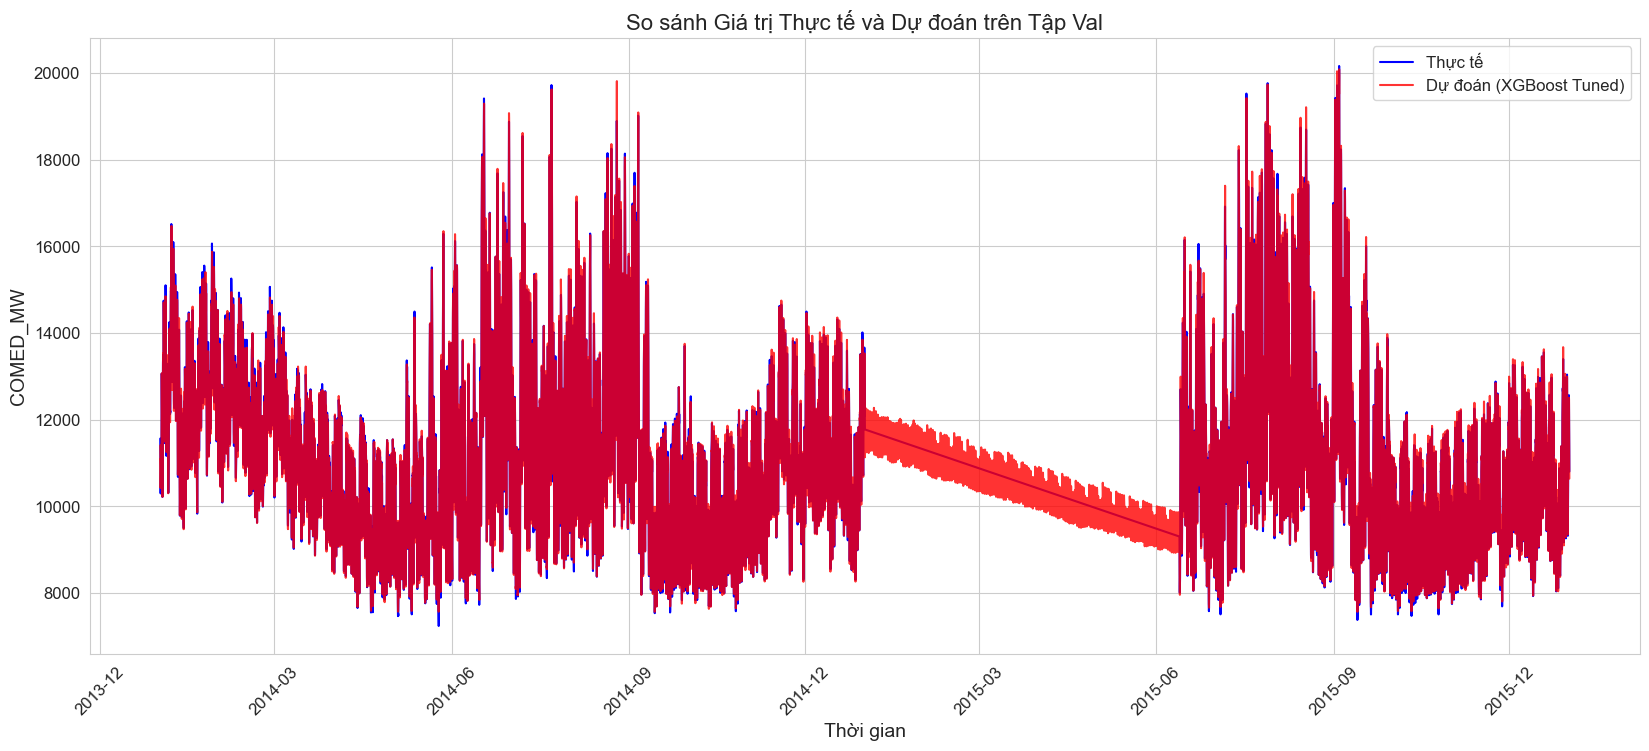

In [71]:
# Vẽ biểu đồ toàn bộ tập Val
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(val_results_final_df.index, val_results_final_df['Actual'], label='Thực tế', lw=1.5, color='blue')
ax.plot(val_results_final_df.index, val_results_final_df['Predicted (XGB)'], label='Dự đoán (XGBoost Tuned)', alpha=0.8, lw=1.5, color='red')
ax.set_title('So sánh Giá trị Thực tế và Dự đoán trên Tập Val')
ax.set_xlabel('Thời gian')
ax.set_ylabel(data_col)
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()



Phân tích Phần dư (Residuals) trên tập val:


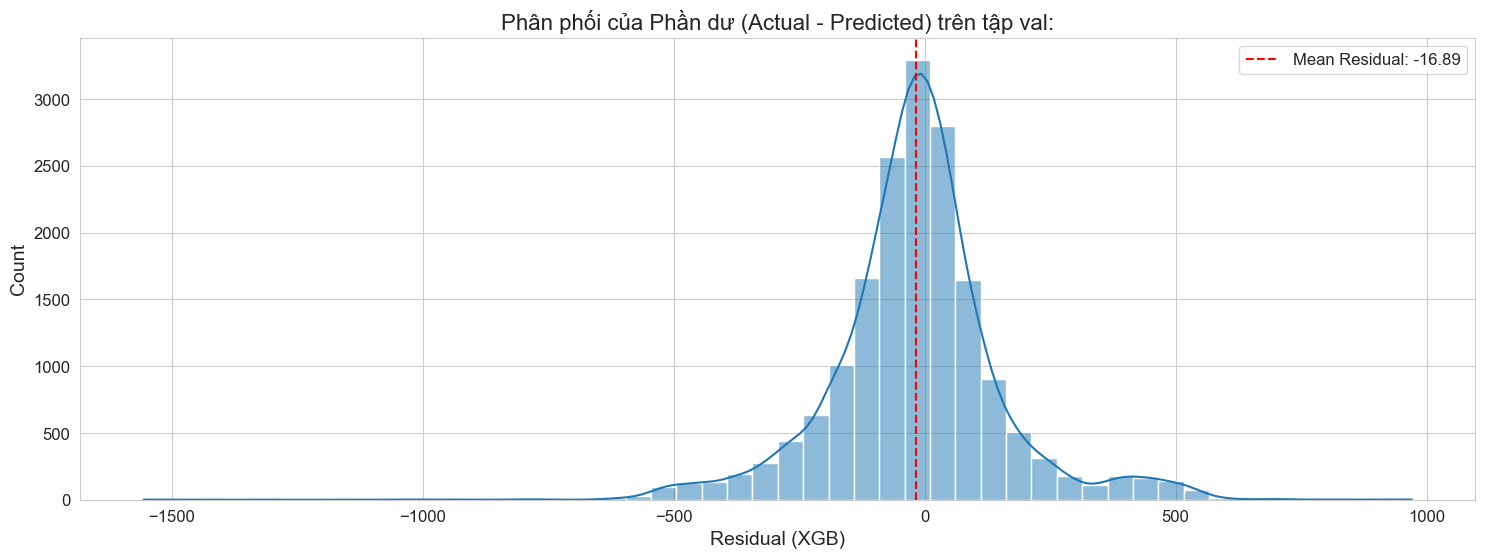

In [72]:
print("\nPhân tích Phần dư (Residuals) trên tập val:")
plt.figure(figsize=(18, 6))
sns.histplot(val_results_final_df['Residual (XGB)'], kde=True, bins=50)
plt.title('Phân phối của Phần dư (Actual - Predicted) trên tập val:')
residual_mean = val_results_final_df['Residual (XGB)'].mean()
plt.axvline(residual_mean, color='red', linestyle='--', label=f'Mean Residual: {residual_mean:,.2f}')
plt.legend()
plt.show()

yo



--- Độ quan trọng của các Đặc trưng (XGBoost Tuned) ---


,Feature,Importance
0,COMED_MW_lag_1,0.925161
1,hour_cos,0.022644
2,hour,0.016267
3,COMED_MW_lag_2,0.005778
4,dayofweek,0.003507
5,COMED_MW_lag_3,0.003454
6,COMED_MW_roll_std_3,0.002880
7,hour_sin,0.002846
8,COMED_MW_roll_mean_24,0.002704
9,month_cos,0.002377


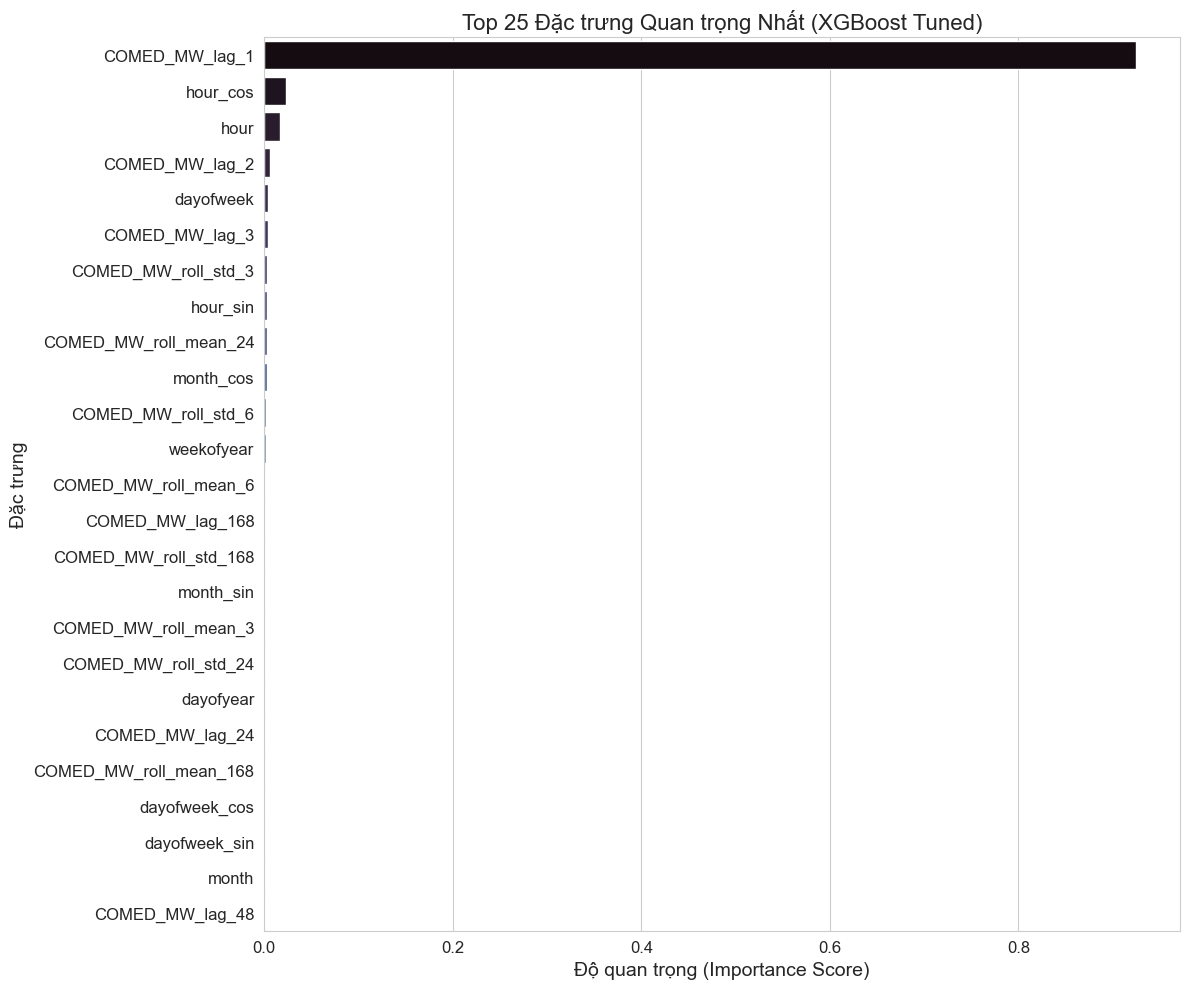

In [73]:
print("\n--- Độ quan trọng của các Đặc trưng (XGBoost Tuned) ---")
try:
    # Lấy feature importance trực tiếp từ model đã fit
    feature_importance_final = final_xgb_model.feature_importances_
    importance_final_df = pd.DataFrame({'Feature': FEATURES, 'Importance': feature_importance_final})
    importance_final_df = importance_final_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    display(importance_final_df.head(20)) # Hiển thị top 20

    # Trực quan hóa top N features
    n_top_features = 25
    plt.figure(figsize=(12, n_top_features * 0.4)) # Điều chỉnh chiều cao dựa trên số features
    sns.barplot(x='Importance', y='Feature', data=importance_final_df.head(n_top_features), palette='mako', orient='h')
    plt.title(f'Top {n_top_features} Đặc trưng Quan trọng Nhất (XGBoost Tuned)')
    plt.xlabel('Độ quan trọng (Importance Score)')
    plt.ylabel('Đặc trưng')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Lỗi khi lấy/vẽ feature importance: {e}")

Đấm nhau với tập test


In [74]:
df_feature_1_to_test = create_time_features(df_test)
df_feature_2_to_test = add_lag_features(df_feature_1_to_test, TARGET, lags_to_add)
df_feature_3_to_test = add_rolling_window_features(df_feature_2_to_test, TARGET, windows_to_add, aggs=aggregations)
df_final_features_to_test = df_feature_3_to_test.dropna()

X_test = df_final_features_to_test[FEATURES]
y_test = df_final_features_to_test[TARGET]


In [75]:
y_pred_test_final = final_xgb_model.predict(X_test)

In [76]:
test_results_final_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test_final,
    'Residual': y_test - y_pred_test_final
}, index=y_test.index)

print("\nSo sánh Thực tế và Dự đoán trên tập Test:")
display(test_results_final_df.head())


So sánh Thực tế và Dự đoán trên tập Test:


,Actual,Predicted,Residual
Datetime,,,
2015-06-06 16:00:00,10202.0,10056.079102,145.920898
2015-06-06 17:00:00,10283.0,10103.067383,179.932617
2015-06-06 18:00:00,10389.0,10365.559570,23.440430
2015-06-06 19:00:00,10399.0,10474.655273,-75.655273
2015-06-06 20:00:00,10140.0,10410.927734,-270.927734


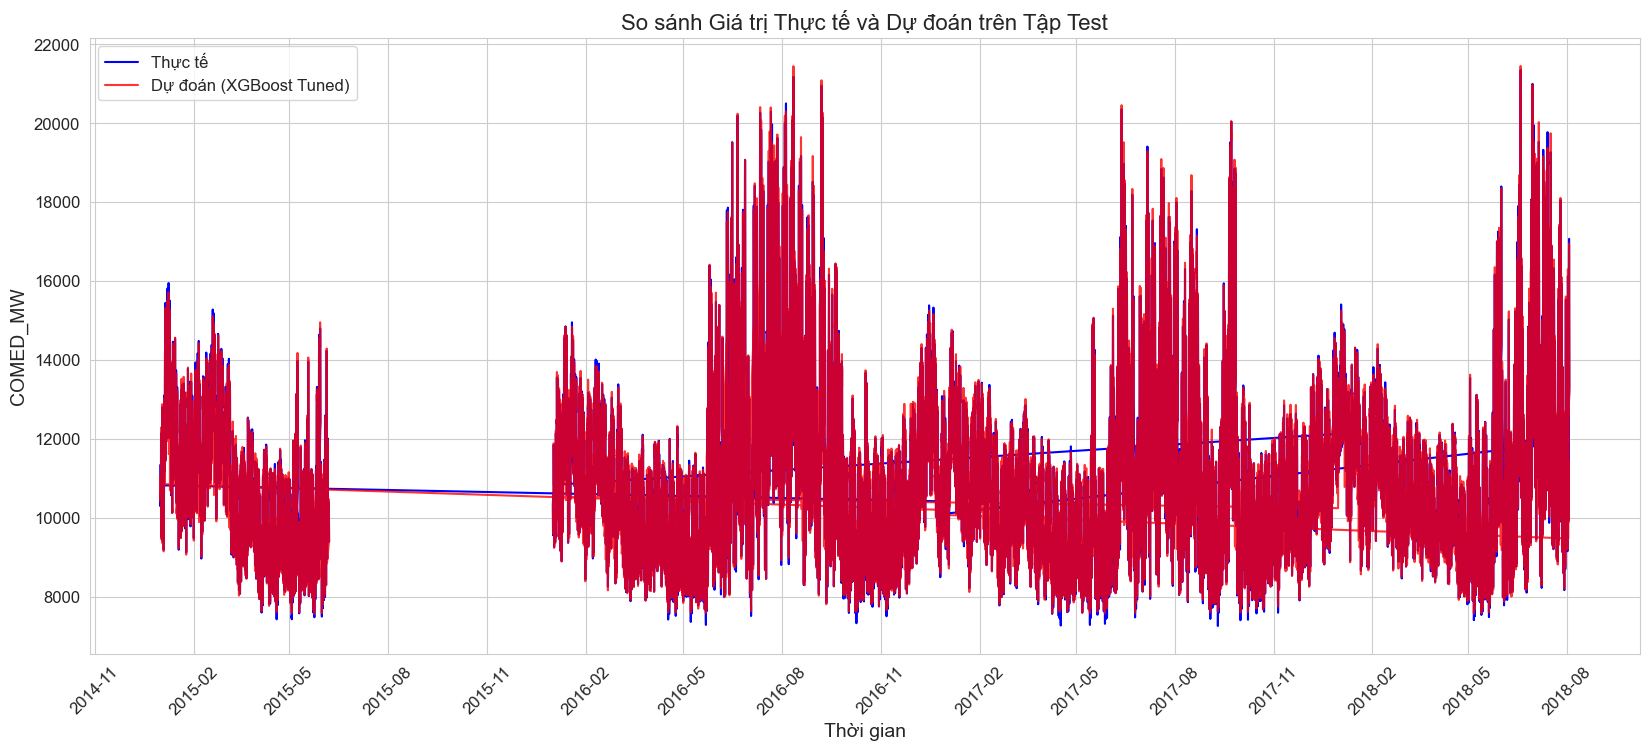

In [77]:
# Vẽ biểu đồ toàn bộ tập test
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(test_results_final_df.index, test_results_final_df['Actual'], label='Thực tế', lw=1.5, color='blue')
ax.plot(test_results_final_df.index, test_results_final_df['Predicted'], label='Dự đoán (XGBoost Tuned)', alpha=0.8, lw=1.5, color='red')
ax.set_title('So sánh Giá trị Thực tế và Dự đoán trên Tập Test')
ax.set_xlabel('Thời gian')
ax.set_ylabel(data_col)
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()


In [78]:
print("MAE:", mean_absolute_error(y_test, y_pred_test_final))
print("RMSE:", mean_squared_error(y_test, y_pred_test_final, squared=False))
print("R2:", r2_score(y_test, y_pred_test_final))


MAE: 132.15109126268632
RMSE: 275.87670042816114
R2: 0.9843245484257518



Phân tích Phần dư (Residuals) trên tập test:


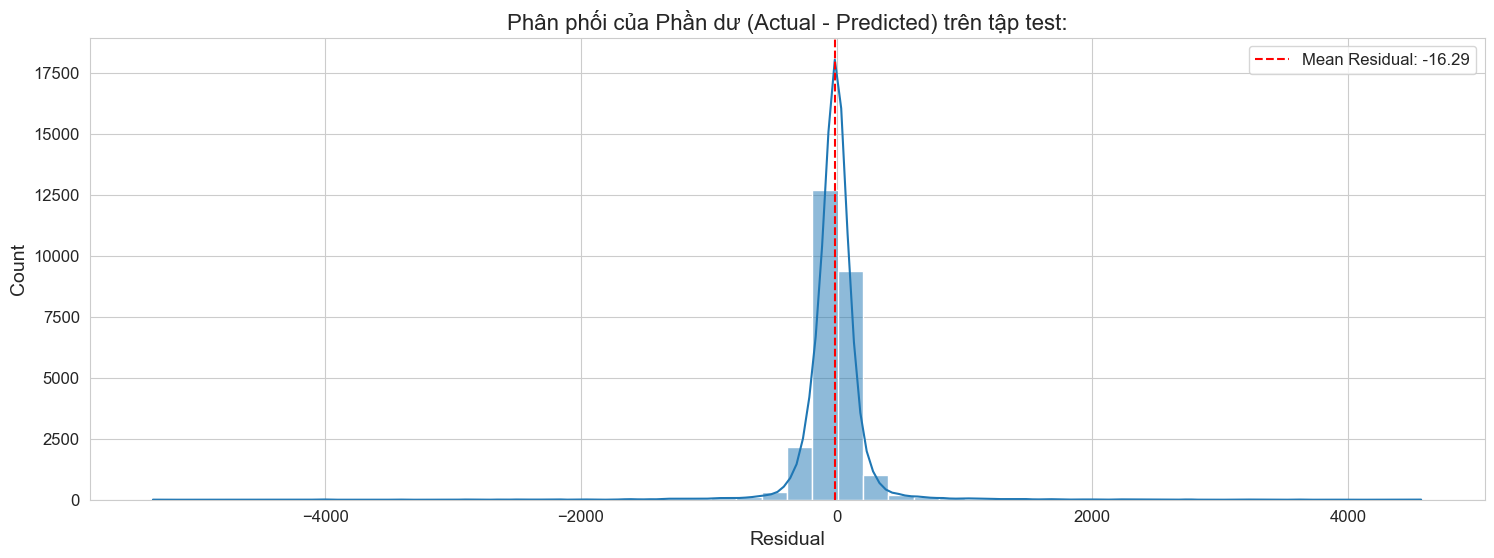

In [79]:
print("\nPhân tích Phần dư (Residuals) trên tập test:")
plt.figure(figsize=(18, 6))
sns.histplot(test_results_final_df['Residual'], kde=True, bins=50)
plt.title('Phân phối của Phần dư (Actual - Predicted) trên tập test:')
residual_mean = test_results_final_df['Residual'].mean()
plt.axvline(residual_mean, color='red', linestyle='--', label=f'Mean Residual: {residual_mean:,.2f}')
plt.legend()
plt.show()